📊 Diabetic_data: Loaded 101766 records
⚙️ Optimizing Weighted Multiclass model for Diabetic_data...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
📈 Diabetic_data Weighted Accuracy: 53.76%

📝 Detailed Classification Report:
              precision    recall  f1-score   support

          NO       0.66      0.65      0.66     16459
         >30       0.46      0.46      0.46     10664
         <30       0.20      0.22      0.21      3407

    accuracy                           0.54     30530
   macro avg       0.44      0.44      0.44     30530
weighted avg       0.54      0.54      0.54     30530



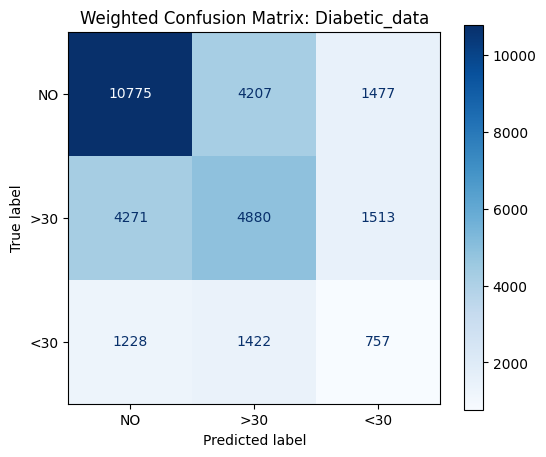

In [1]:
import os
import pandas as pd
import pickle
import xgboost as xgb
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

# ---------------- CONFIG ----------------
CLIENT_NAME = "Diabetic_data" 

try:
    BASE_PATH = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_PATH = os.getcwd()

# 1. UPDATED DATA PATH
LOCAL_DATA_PATH = r"E:\semm 8\federated_learning\federated_3\data_preprosses\diabetic_data.csv"

# 2. Correct Path to Server 
SERVER_DIR = os.path.abspath(os.path.join(BASE_PATH, "..", "server"))
CLIENT_WEIGHTS_DIR = os.path.join(SERVER_DIR, "clients_weights")

os.makedirs(CLIENT_WEIGHTS_DIR, exist_ok=True)

WEIGHTS_PATH = os.path.join(CLIENT_WEIGHTS_DIR, f"{CLIENT_NAME}_weights.pkl")
META_PATH = os.path.join(CLIENT_WEIGHTS_DIR, f"{CLIENT_NAME}_info.json")

# ---------------- LOAD DATA ----------------
if not os.path.exists(LOCAL_DATA_PATH):
    raise FileNotFoundError(f"❌ Data file not found! Check the path: {LOCAL_DATA_PATH}")

data = pd.read_csv(LOCAL_DATA_PATH)
print(f"📊 {CLIENT_NAME}: Loaded {len(data)} records")

# ---------------- PREPROCESS ----------------
features = [
    'race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
    'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed', 'A1Cresult', 
    'max_glu_serum', 'weight'
]

gender_map = {'Male': 0, 'Female': 1, 'Unknown/Invalid': 2}
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, 
    '[80-90)': 85, '[90-100)': 95
}

data['gender'] = data['gender'].map(gender_map).fillna(2)
data['age'] = data['age'].map(age_map).fillna(45)

for col in features:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))

# ---------------- TARGET TRANSFORMATION ----------------
target_map = {"NO": 0, ">30": 1, "<30": 2}
if 'readmitted' in data.columns:
    data["Readmitted_Target"] = data["readmitted"].map(target_map).fillna(0).astype(int)
else:
    data["Readmitted_Target"] = data["Readmitted_Target"].astype(int)

X = data[features]
y = data["Readmitted_Target"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

# ---------------- SAMPLE WEIGHTING (ACCURACY BOOST FOR <30) ----------------
# We compute weights so the model penalizes missing the minority class (<30) more heavily.
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# ---------------- HYPERPARAMETER TUNING ----------------
print(f"⚙️ Optimizing Weighted Multiclass model for {CLIENT_NAME}...")

param_grid = {
    'n_estimators': [150, 250],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2]
}

xgb_base = xgb.XGBClassifier(
    objective="multi:softprob", 
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist", 
    device="cpu",
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring='f1_macro', # Changed to f1_macro to better value minority class performance
    cv=3, 
    n_jobs=2,
    random_state=42,
    verbose=1
)

# Pass sample_weights to the fit function
random_search.fit(X_train, y_train, sample_weight=sample_weights)
local_model = random_search.best_estimator_

# ---------------- EVALUATION ----------------
y_pred = local_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
cm = confusion_matrix(y_test, y_pred)

print(f"📈 {CLIENT_NAME} Weighted Accuracy: {accuracy:.2f}%")
print("\n📝 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["NO", ">30", "<30"]))

# Visualization
fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", ">30", "<30"])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title(f"Weighted Confusion Matrix: {CLIENT_NAME}")
plt.show()

# # ---------------- SAVE & UPLOAD ----------------
# with open(WEIGHTS_PATH, "wb") as f:
#     pickle.dump(local_model, f) 

# meta = {
#     "client": CLIENT_NAME,
#     "records_used": len(data),
#     "accuracy": round(accuracy, 2),
#     "best_params": random_search.best_params_,
#     "type": "multiclass_weighted"
# }

# with open(META_PATH, "w") as f:
#     json.dump(meta, f, indent=4)

# print(f"✅ Success! {CLIENT_NAME} weighted multiclass update sent to Server.")


📊 Training Accuracy (Diabetic_data): 79.74%
📊 Testing Accuracy (Diabetic_data): 53.76%
🎯 Micro F1-score: 0.5376
🎯 Macro F1-score: 0.4437
🎯 Weighted F1-score: 0.5396
📈 AUC–ROC (Macro, OvR): 0.6512

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     16459
           1       0.46      0.46      0.46     10664
           2       0.20      0.22      0.21      3407

    accuracy                           0.54     30530
   macro avg       0.44      0.44      0.44     30530
weighted avg       0.54      0.54      0.54     30530



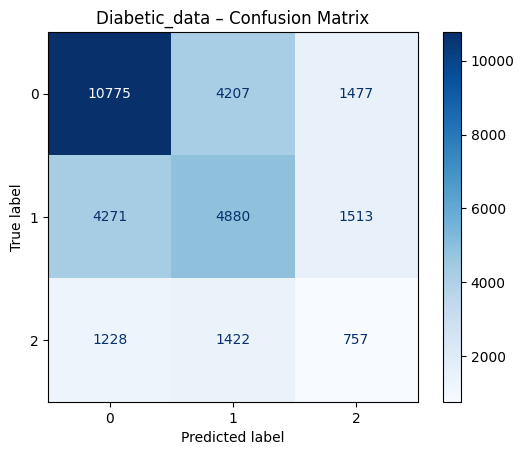


✅ Model, metrics & metadata successfully sent to server from Diabetic_data


In [2]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score
)

# ---------------- EVALUATION ----------------

# Predictions
y_train_pred = local_model.predict(X_train)
y_test_pred = local_model.predict(X_test)

# Probabilities (needed for AUC-ROC)
y_test_proba = local_model.predict_proba(X_test)

# ---------------- ACCURACY ----------------
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

# ---------------- F1 SCORES ----------------
micro_f1 = f1_score(y_test, y_test_pred, average="micro")
macro_f1 = f1_score(y_test, y_test_pred, average="macro")
weighted_f1 = f1_score(y_test, y_test_pred, average="weighted")

# ---------------- AUC-ROC (MULTICLASS) ----------------
auc_roc = roc_auc_score(
    y_test,
    y_test_proba,
    multi_class="ovr",
    average="macro"
)

# ---------------- PRINT RESULTS ----------------
print(f"\n📊 Training Accuracy ({CLIENT_NAME}): {train_accuracy:.2f}%")
print(f"📊 Testing Accuracy ({CLIENT_NAME}): {test_accuracy:.2f}%")
print(f"🎯 Micro F1-score: {micro_f1:.4f}")
print(f"🎯 Macro F1-score: {macro_f1:.4f}")
print(f"🎯 Weighted F1-score: {weighted_f1:.4f}")
print(f"📈 AUC–ROC (Macro, OvR): {auc_roc:.4f}")

print("\n📄 Classification Report:")
print(classification_report(y_test, y_test_pred))

# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"{CLIENT_NAME} – Confusion Matrix")
plt.show()

# ---------------- SAVE MODEL ----------------
with open(WEIGHTS_PATH, "wb") as f:
    pickle.dump(local_model, f)

# ---------------- SAVE METADATA (FOR SERVER) ----------------
meta = {
    "client": CLIENT_NAME,
    "train_accuracy_percent": round(train_accuracy, 2),
    "test_accuracy_percent": round(test_accuracy, 2),
    "micro_f1": round(micro_f1, 4),
    "macro_f1": round(macro_f1, 4),
    "weighted_f1": round(weighted_f1, 4),
    "auc_roc_macro_ovr": round(auc_roc, 4),
    "num_train_samples": len(X_train),
    "num_test_samples": len(X_test)
}

with open(META_PATH, "w") as f:
    json.dump(meta, f, indent=4)

print(f"\n✅ Model, metrics & metadata successfully sent to server from {CLIENT_NAME}")
